In [1]:
!pip install -U segmentation-models-pytorch
!pip install torchmetrics
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 680.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=2da7992864b60a252f896c790049a3d4f07d9f33a06c19676886dcd5930a46b1
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=801e862d15f0400c2fc74365baa7506a526b32fb1e8570a4c1533d831ac2a716
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import segmentation_models_pytorch as smp

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

import os
import json


In [4]:
DATA_PATH = os.path.join("../input/realdata-segy", "256Window")
train_path = os.path.join(DATA_PATH, "train")
eval_path = os.path.join(DATA_PATH, "eval")
val_path = os.path.join(DATA_PATH, "val")

with open(os.path.join(train_path, "metadata.json"), "r") as file:
    train_list = json.load(file)
with open(os.path.join(eval_path, "metadata.json"), "r") as file:
    eval_list = json.load(file)
with open(os.path.join(val_path, "metadata.json"), "r") as file:
    val_list = json.load(file)
eval_list = val_list
len(train_list), len(eval_list), len(val_list)

(9000, 1000, 1000)

In [5]:
class FaultDataset(Dataset):
    def __init__(self, data, transform, data_path):
        self.data = data
        self.transform = transform
        self.data_path = data_path

    def __getitem__(self, index):
        record = self.data[index]
        seis = Image.open(os.path.join(self.data_path, "seis", record["data"]))
        if self.transform is not None:
            seis = self.transform(seis)
        label = Image.open(os.path.join(self.data_path, "fault", record["label"]))
        label = transforms.ToTensor()(label)
        return seis, label

    def __len__(self):
        return len(self.data)
preprocess = transforms.Compose([
    transforms.ToTensor()])

train_dataset = FaultDataset(train_list, preprocess, train_path)
eval_dataset = FaultDataset(eval_list, preprocess, eval_path)
val_dataset = FaultDataset(val_list, preprocess, val_path)

# print(train_dataset.__getitem__(0)[0].shape)

BATCH_SIZE = 10
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, BATCH_SIZE)
val_loader = DataLoader(val_dataset, 1)
print(len(train_loader), len(eval_loader), len(val_loader))

900 100 1000


In [6]:
class LitModel(pl.LightningModule):
    def __init__(self, model, loss):
        super().__init__()
        self.model = model
        self.loss = loss
        self.valid_loss = []
        self.train_loss = []

    def forward(self, x):
        y_pred = self.model(x)
        return y_pred
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer
    
    def get_metrics(self, y_pred, y, metrics_type="train"):
        values = smp.metrics.functional.get_stats((y_pred > 0.5).type(torch.int32),
                                                  y.type(torch.int32), mode='binary')
        iou = smp.metrics.functional.iou_score(*values)
        self.log(f'iou/{metrics_type}', torch.mean(iou))
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        # self.train_loss.append(loss)
        self.get_metrics(y_pred, y, 'train')
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch

        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        # self.valid_loss.append(loss)
        self.get_metrics(y_pred, y, 'valid')
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch

        y_pred = self.forward(x)
        loss = self.loss(y_pred, y)
        self.get_metrics(y_pred, y, 'test')
        return loss

## DiceLoss

In [9]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6",encoder_weights="imagenet",
                          in_channels=1, classes=1,activation='sigmoid')
loss = smp.losses.DiceLoss('binary')
deeplab_model = LitModel(model, loss)
trainer_deeplab_model = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer_deeplab_model.fit(deeplab_model, train_loader, eval_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [10]:
trainer_deeplab_model.test(deeplab_model, val_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         iou/test          │    0.3451167643070221     │
└───────────────────────────┴───────────────────────────┘

[{'iou/test': 0.3451167643070221}]

## TverskyLoss

In [8]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6",encoder_weights="imagenet",
                          in_channels=1, classes=1,activation='sigmoid')
loss = smp.losses.TverskyLoss('binary')
unet_model = LitModel(model, loss)
trainer_unet_model = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer_unet_model.fit(unet_model, train_loader, eval_loader)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
trainer_unet_model.test(unet_model, val_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         iou/test          │    0.3414561152458191     │
└───────────────────────────┴───────────────────────────┘

[{'iou/test': 0.3414561152458191}]

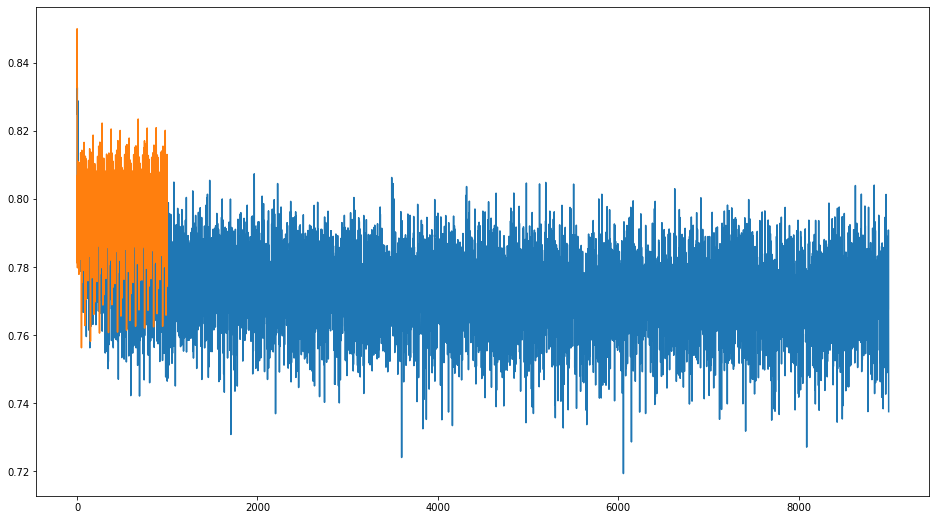

In [12]:
train_loss = [i.cpu() for i in unet_model.train_loss]
valid_loss = [i.cpu() for i in unet_model.valid_loss]
plt.figure(figsize=(16,9))
plt.plot([i.detach().numpy() for i in train_loss])
plt.plot([i.detach().numpy() for i in valid_loss])

## JaccardLoss

In [9]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6",encoder_weights="imagenet",
                          in_channels=1, classes=1,activation='sigmoid')
loss = smp.losses.JaccardLoss('binary')
deeplab_model = LitModel(model, loss)
trainer_deeplab_model = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer_deeplab_model.fit(deeplab_model, train_loader, eval_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
trainer_deeplab_model.test(deeplab_model, val_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         iou/test          │    0.3393067419528961     │
└───────────────────────────┴───────────────────────────┘

[{'iou/test': 0.3393067419528961}]

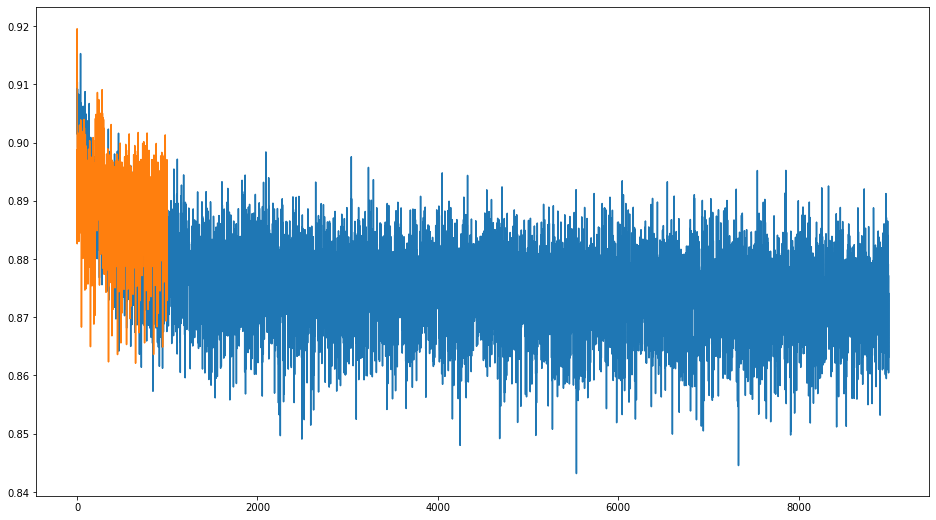

In [33]:
train_loss = [i.cpu() for i in unet_model.train_loss]
valid_loss = [i.cpu() for i in unet_model.valid_loss]
plt.figure(figsize=(16,9))
plt.plot([i.detach().numpy() for i in train_loss])
plt.plot([i.detach().numpy() for i in valid_loss])

In [ ]:
# res = unet_model.model(x)
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(32, 18))
# ax1.imshow(((res)).detach().numpy()[0][0])
# ax2.imshow(y[0][0])
# ax3.imshow(x[0][0])

## CustomDiceLoss

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, thresh=0.5):
        super().__init__()
        self.thresh = thresh

    def forward(self, inputs, targets, smooth=1e-6):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()

        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [8]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6",encoder_weights="imagenet",
                          in_channels=1, classes=1,activation='sigmoid')
loss = DiceLoss()
deeplab_model = LitModel(model, loss)
trainer_deeplab_model = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer_deeplab_model.fit(deeplab_model, train_loader, eval_loader)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
trainer_deeplab_model.test(deeplab_model, val_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         iou/test          │    0.3703806698322296     │
└───────────────────────────┴───────────────────────────┘

[{'iou/test': 0.3703806698322296}]

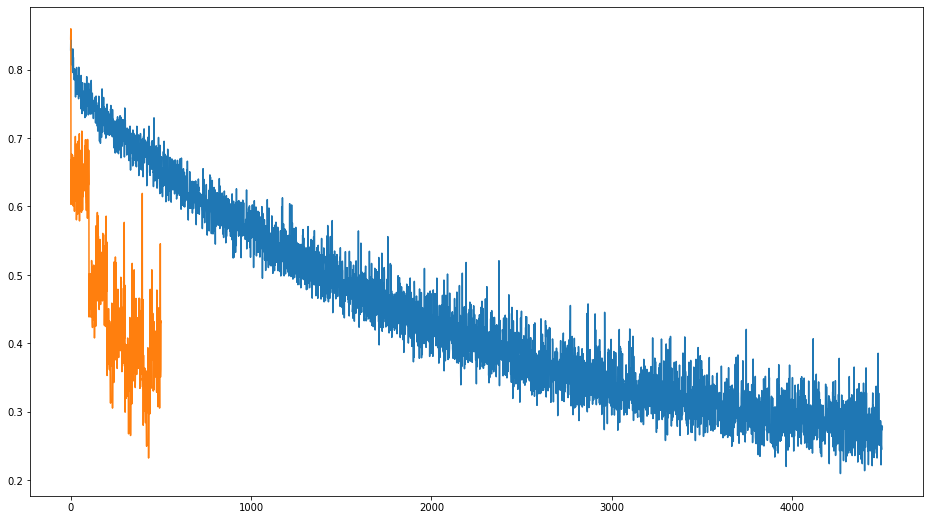

In [50]:
train_loss = [i.cpu() for i in unet_model.train_loss]
valid_loss = [i.cpu() for i in unet_model.valid_loss]
plt.figure(figsize=(16,9))
plt.plot([i.detach().numpy() for i in train_loss])
plt.plot([i.detach().numpy() for i in valid_loss])

## MCCLoss

In [8]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6",encoder_weights="imagenet",
                          in_channels=1, classes=1,activation='sigmoid')
loss = smp.losses.MCCLoss()
deeplab_model = LitModel(model, loss)
trainer_deeplab_model = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer_deeplab_model.fit(deeplab_model, train_loader, eval_loader)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [10]:
trainer_deeplab_model.test(deeplab_model, val_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         iou/test          │    0.3666517734527588     │
└───────────────────────────┴───────────────────────────┘

[{'iou/test': 0.3666517734527588}]

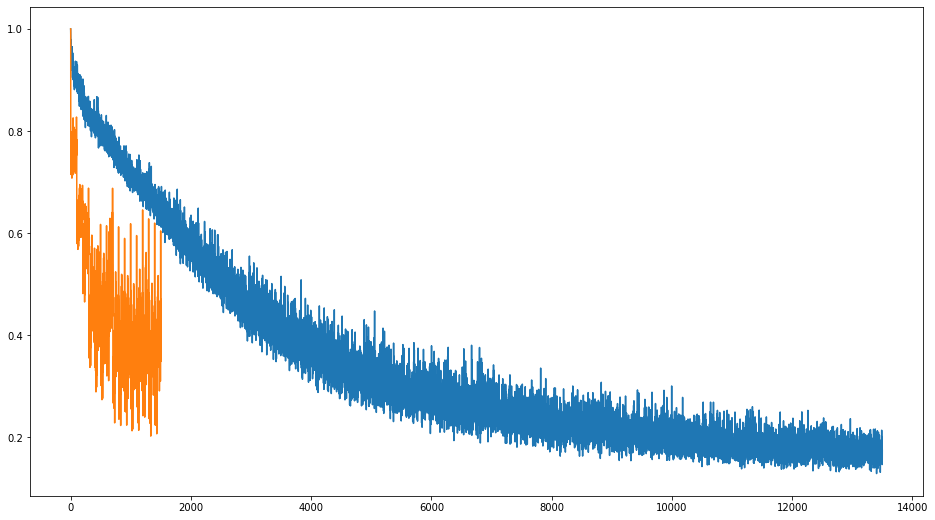

In [32]:
train_loss = [i.cpu() for i in unet_model.train_loss]
valid_loss = [i.cpu() for i in unet_model.valid_loss]
plt.figure(figsize=(16,9))
plt.plot([i.detach().numpy() for i in train_loss])
plt.plot([i.detach().numpy() for i in valid_loss])

## FocalLoss

In [7]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6",encoder_weights="imagenet",
                          in_channels=1, classes=1,activation='sigmoid')
loss = smp.losses.FocalLoss(mode='binary', alpha=0.1)
deeplab_model = LitModel(model, loss)
trainer_deeplab_model = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer_deeplab_model.fit(deeplab_model, train_loader, eval_loader)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
trainer_deeplab_model.test(deeplab_model, val_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         iou/test          │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'iou/test': 0.0}]

In [ ]:
train_loss = [i.cpu() for i in unet_model.train_loss]
valid_loss = [i.cpu() for i in unet_model.valid_loss]
plt.figure(figsize=(16,9))
plt.plot([i.detach().numpy() for i in train_loss])
plt.plot([i.detach().numpy() for i in valid_loss])

## LovaszLoss

In [7]:
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b6",encoder_weights="imagenet",
                          in_channels=1, classes=1,activation='sigmoid')
loss = smp.losses.LovaszLoss(mode='binary')
deeplab_model = LitModel(model, loss)
trainer_deeplab_model = pl.Trainer(max_epochs=10, accelerator='gpu')
trainer_deeplab_model.fit(deeplab_model, train_loader, eval_loader)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [8]:
trainer_deeplab_model.test(deeplab_model, val_loader)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         iou/test          │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'iou/test': 0.0}]